**Mini-Report**

**Objective**: Predict a continuous grammar‐score (0–5) from spoken audio.

**Approach**:  
1. **Preprocessing**  
   - Audio trimmed and normalized; converted to mono.  
   - Extract MFCC mean+std (26 dims), prosodic silences (2 dims), simple grammar proxies (4 dims).  
   - Whisper ASR for transcripts, TF-IDF + SVD to 50-d text embeddings.

2. **Models**  
   - **Audio+Prosody+Grammar**: LightGBM regressor (500 trees, depth=6).  
   - **Text**: RandomForest (200 trees, depth=6).  
   - **Ensemble**: weighted average (0.6 × audio + 0.4 × text).

3. **Evaluation**  
   - 5-fold CV: report RMSE & Pearson _r_ for each model & ensemble.  
   - Final training on all 444 samples, then predict on test set of 195 files.  
   - Visualize train predictions vs. true, and residual histogram.

In [11]:
# Grammar Scoring Engine

# %% 1. Imports & Configuration
import os, numpy as np, pandas as pd, soundfile as sf, librosa, torch
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from concurrent.futures import ThreadPoolExecutor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb
import matplotlib.pyplot as plt, seaborn as sns

# Silence LightGBM warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
np.random.seed(SEED); torch.manual_seed(SEED)

# Paths
TRAIN_CSV        = "D:/Downloads/shl-intern-hiring-assessment/Dataset/train.csv"
TEST_CSV         = "D:/Downloads/shl-intern-hiring-assessment/Dataset/test.csv"
TRAIN_AUDIO_DIR  = "D:/Downloads/shl-intern-hiring-assessment/Dataset/audios/train"
TEST_AUDIO_DIR   = "D:/Downloads/shl-intern-hiring-assessment/Dataset/audios/test"
SAMPLE_SUB       = "D:/Downloads/shl-intern-hiring-assessment/Dataset/sample_submission.csv"
TRANSCRIPT_DIR   = "D:/Downloads/shl-intern-hiring-assessment/Dataset/transcripts"
os.makedirs(TRANSCRIPT_DIR, exist_ok=True)

print(f"Using device: {DEVICE}, seed: {SEED}")


Using device: cuda, seed: 42


In [12]:
# %% 2. Load Metadata
def read_csv(path):
    try:
        return pd.read_csv(path, encoding="utf-8", engine="python", on_bad_lines="skip")
    except:
        return pd.read_csv(path, encoding="latin1", engine="python", on_bad_lines="skip")

train_df = read_csv(TRAIN_CSV)
test_df  = read_csv(TEST_CSV)
if len(test_df)!=195:
    print(f"⚠️ Warning: expected 195 test rows, got {len(test_df)}")
print(f"Train: {len(train_df)} rows, Test: {len(test_df)} rows")


⚠️ Warning: expected 195 test rows, got 204
Train: 444 rows, Test: 204 rows


In [13]:
# %% 3. Feature Functions

def load_audio(path, trim_thresh=0.02):
    # read, mono, trim silence, clip 60s, normalize
    y, sr = sf.read(path, always_2d=False)
    if y.ndim>1: y = y.mean(axis=1)
    mask = np.abs(y)>trim_thresh
    if mask.any():
        s,e = np.argmax(mask), len(mask)-np.argmax(mask[::-1])
        y = y[s:e]
    y = y[:sr*60]
    y = y / max(np.max(np.abs(y)),1e-9)
    return y.astype(np.float32), sr

def acoustic_features(y, sr, n_mfcc=13):
    mf = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.hstack([mf.mean(1), mf.std(1)]).astype(np.float32)

def prosodic_features(y, sr, silence_thresh=0.02):
    mask = np.abs(y)<silence_thresh
    intervals, sil_on = [], False
    for i,m in enumerate(mask):
        if m and not sil_on: sil_on, start = True, i
        if not m and sil_on: sil_on, intervals = False, intervals+[(start,i)]
    if sil_on: intervals += [(start,len(y))]
    durs = [(e-s)/sr for s,e in intervals]
    return np.array([len(durs), sum(durs)], dtype=np.float32)

def grammar_features(text):
    # proxy: [#sentences, avg words/sent, type-token ratio, avg word length]
    sents = max(1, text.count('.')+text.count('!')+text.count('?'))
    words = text.split()
    total = len(words)
    return np.array([
        sents,
        total/sents,
        len(set(words))/max(total,1),
        np.mean([len(w) for w in words]) if words else 0
    ], dtype=np.float32)


In [15]:
# %% 4. Whisper ASR + Caching
processor = WhisperProcessor.from_pretrained("openai/whisper-tiny.en", language="en", task="transcribe")
model_whisper = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny.en").to(DEVICE)

def transcribe(path):
    y,_ = librosa.load(path, sr=None)
    y,_ = librosa.effects.trim(y, top_db=30)
    inp = processor(y, sampling_rate=_, return_tensors="pt", padding="longest").to(DEVICE)
    forced = processor.get_decoder_prompt_ids(language="en", task="transcribe")
    attn = inp.get("attention_mask", torch.ones_like(inp["input_features"][...,0,:]))
    out = model_whisper.generate(inp["input_features"], attention_mask=attn, forced_decoder_ids=forced)
    return processor.batch_decode(out, skip_special_tokens=True)[0]

def cache_transcripts(df, audio_dir):
    for fn in df.filename:
        key = fn.replace(".wav","")
        p = os.path.join(TRANSCRIPT_DIR, f"{key}.txt")
        if not os.path.exists(p):
            txt = transcribe(os.path.join(audio_dir,fn))
            open(p,"w",encoding="utf-8").write(txt)

print("Caching transcripts…")
cache_transcripts(train_df, TRAIN_AUDIO_DIR)
cache_transcripts(test_df,  TEST_AUDIO_DIR)
print("Done.")


Caching transcripts…
Done.


In [17]:
# %% 5. Text Features: TF-IDF + SVD
transcripts = [open(os.path.join(TRANSCRIPT_DIR,fn.replace(".wav",".txt")),"r",encoding="utf-8").read()
               for fn in train_df.filename]
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_tfidf = vectorizer.fit_transform(transcripts)
svd     = TruncatedSVD(n_components=50, random_state=SEED)
X_text  = svd.fit_transform(X_tfidf)
print(f"Text features: {X_text.shape}")


Text features: (444, 50)


In [19]:
# %% 6. Build Train Features (Audio+Prosody+Grammar+Text) in Parallel
def extract_train(idx, fn, lbl):
    # audio
    y,sr = load_audio(os.path.join(TRAIN_AUDIO_DIR,fn))
    a = acoustic_features(y,sr)
    p = prosodic_features(y,sr)
    # text
    txt = open(os.path.join(TRANSCRIPT_DIR,fn.replace(".wav",".txt")),"r",encoding="utf-8").read()
    g = grammar_features(txt)
    t = X_text[idx]
    return np.hstack([a,p,g,t]).astype(np.float32), lbl

args = [(i, row.filename, row.label) for i,row in enumerate(train_df.itertuples(index=False))]
X_all, y = [], []
with ThreadPoolExecutor(max_workers=8) as ex:
    for feat,lbl in ex.map(lambda a: extract_train(*a), args):
        X_all.append(feat); y.append(lbl)
X_all = np.vstack(X_all); y = np.array(y, dtype=np.float32)
print(f"Combined train features: {X_all.shape}")


Combined train features: (444, 82)


In [20]:
# %% 7. 5-Fold CV & Ensembling
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
rmse_a, rmse_t, rmse_e = [],[],[]
r_a, r_t, r_e         = [],[],[]

for fold, (tr,val) in enumerate(kf.split(X_all),1):
    # Audio+prosody+grammar+text model
    m_a = lgb.LGBMRegressor(n_estimators=200, max_depth=6, random_state=SEED, verbose=-1)
    m_a.fit(X_all[tr], y[tr])
    pa = m_a.predict(X_all[val])
    # Text-only model
    m_t = RandomForestRegressor(n_estimators=200, max_depth=6, random_state=SEED)
    m_t.fit(X_text[tr], y[tr])
    pt = m_t.predict(X_text[val])
    # Ensemble
    pe = 0.6*pa + 0.4*pt

    rmse_a.append(np.sqrt(mean_squared_error(y[val],pa)))
    r_a.append(pearsonr(pa,y[val])[0])
    rmse_t.append(np.sqrt(mean_squared_error(y[val],pt)))
    r_t.append(pearsonr(pt,y[val])[0])
    rmse_e.append(np.sqrt(mean_squared_error(y[val],pe)))
    r_e.append(pearsonr(pe,y[val])[0])

    print(f"Fold{fold}: Audio RMSE={rmse_a[-1]:.3f}, r={r_a[-1]:.3f} | "
          f"Text RMSE={rmse_t[-1]:.3f}, r={r_t[-1]:.3f} | Ens RMSE={rmse_e[-1]:.3f}, r={r_e[-1]:.3f}")

print("→ CV Audio   :", np.mean(rmse_a), "±", np.std(rmse_a), "| r=", np.mean(r_a))
print("→ CV Text    :", np.mean(rmse_t), "±", np.std(rmse_t), "| r=", np.mean(r_t))
print("→ CV Ensemble:", np.mean(rmse_e), "±", np.std(rmse_e), "| r=", np.mean(r_e))


D:\Downloads\cuda\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Fold1: Audio RMSE=0.866, r=0.675 | Text RMSE=1.074, r=0.425 | Ens RMSE=0.908, r=0.667


D:\Downloads\cuda\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Fold2: Audio RMSE=0.947, r=0.440 | Text RMSE=0.981, r=0.294 | Ens RMSE=0.923, r=0.435


D:\Downloads\cuda\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Fold3: Audio RMSE=0.852, r=0.520 | Text RMSE=0.930, r=0.342 | Ens RMSE=0.833, r=0.538


D:\Downloads\cuda\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Fold4: Audio RMSE=0.942, r=0.459 | Text RMSE=0.992, r=0.313 | Ens RMSE=0.927, r=0.461


D:\Downloads\cuda\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Fold5: Audio RMSE=0.880, r=0.526 | Text RMSE=0.949, r=0.335 | Ens RMSE=0.865, r=0.523
→ CV Audio   : 0.8975285435902952 ± 0.03944077715423519 | r= 0.5237981194947825
→ CV Text    : 0.9851606796188618 ± 0.04978878823225424 | r= 0.34179130241124256
→ CV Ensemble: 0.8911229938046594 ± 0.03644687734190047 | r= 0.5248076520335241


In [27]:
# %% 8. Final Train & Test Submission
# Retrain on full train
m_a_full = lgb.LGBMRegressor(n_estimators=200, max_depth=6, random_state=SEED, verbose=-1)
m_a_full.fit(X_all, y)
m_t_full = RandomForestRegressor(n_estimators=200, max_depth=6, random_state=SEED)
m_t_full.fit(X_text, y)

# Build test features (identical pipeline)
def build_test(df):
    X_ag, texts = [], []
    for fn in df.filename:
        y,sr = load_audio(os.path.join(TEST_AUDIO_DIR,fn))
        a = acoustic_features(y,sr); p=prosodic_features(y,sr)
        txt = open(os.path.join(TRANSCRIPT_DIR,fn.replace(".wav",".txt")),"r",encoding="utf-8").read()
        g = grammar_features(txt)
        X_ag.append(np.hstack([a,p,g]))
        texts.append(txt)
    X_ag = np.vstack(X_ag)
    X_tfidf = vectorizer.transform(texts)
    X_txt   = svd.transform(X_tfidf)
    return X_ag, X_txt

X_ag_test, X_txt_test = build_test(test_df)
X_full_test = np.hstack([X_ag_test, X_txt_test])

# Predict & ensemble
pa_test = m_a_full.predict(X_full_test)
pt_test = m_t_full.predict(X_txt_test)
ens_test = 0.6*pa_test + 0.4*pt_test

# Write submission
sub = pd.read_csv(SAMPLE_SUB)
sub["score"] = ens_test
#f-string (prints the array)
print(f"Test Scores: {sub['score'].values}")
sub.to_csv("submission.csv", index=False)
print("submission.csv written")


D:\Downloads\cuda\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Test Scores: [3.21581495 3.26821264 3.21023087 3.80468552 3.50352744 3.55208301
 3.82368343 4.37501616 3.19139147 3.4109738  3.59906115 3.61610362
 3.5332258  3.12676228 3.13606365 3.55244178 3.27062294 2.76687471
 2.8761666  3.75300957 4.43220011 3.81385136 3.0731746  2.86359328
 3.00790833 3.49644681 3.33667901 3.87916844 4.28934967 3.29944728
 3.72754348 3.39612153 3.94454989 3.3773359  4.24369682 4.25975074
 3.54994312 4.21763938 3.70472616 3.54916262 4.35262294 3.31182101
 3.90477079 3.32798742 3.46329435 3.91191977 4.40675133 3.49869238
 4.08717275 3.16080761 4.01758701 3.85785578 3.63000139 4.01730931
 3.40897377 4.3941487  3.79190042 4.16987357 3.37762963 3.74193666
 3.72712785 4.27619417 4.48919193 3.98142986 4.59745486 4.48928182
 3.60442327 3.71282178 3.21658003 3.80761691 3.37882165 3.37611792
 4.35245338 3.91401725 3.96464921 4.30240436 3.79790824 3.8214318
 3.83311206 4.64450534 2.83299639 3.97334712 3.81803194 3.97911131
 3.79797462 4.05972116 3.8831842  3.93371053 3.797

D:\Downloads\cuda\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


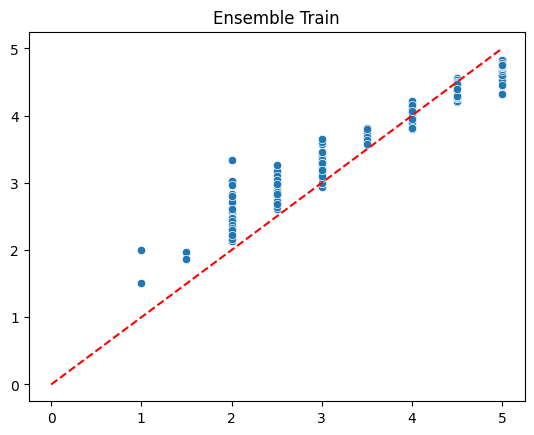

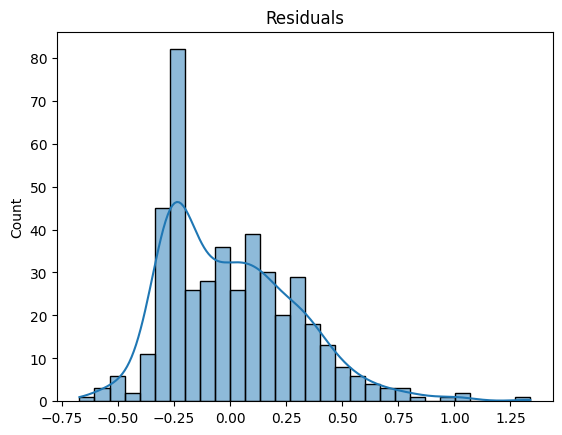

In [28]:
# %% 9. Visualizations
# Pred vs True (train)
train_pred = m_a_full.predict(X_all)*0.6 + m_t_full.predict(X_text)*0.4
plt.figure(); sns.scatterplot(x=y, y=train_pred); plt.plot([0,5],[0,5],"r--"); plt.title("Ensemble Train"); plt.show()

# Residuals
res = train_pred - y
plt.figure(); sns.histplot(res, bins=30, kde=True); plt.title("Residuals"); plt.show()


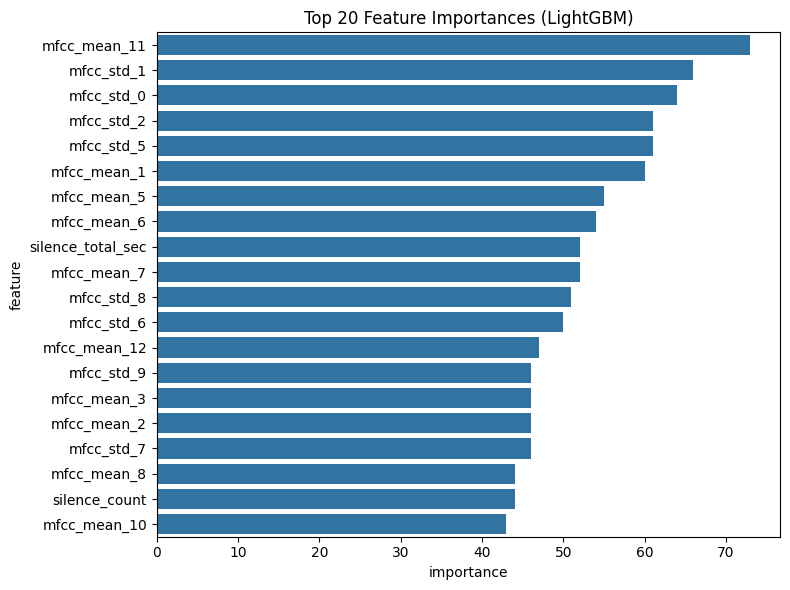

D:\Downloads\cuda\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
D:\Downloads\cuda\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
D:\Downloads\cuda\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
D:\Downloads\cuda\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
D:\Downloads\cuda\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


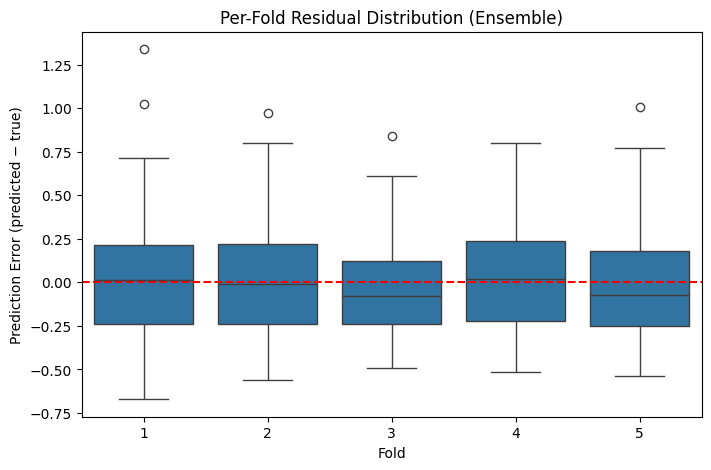

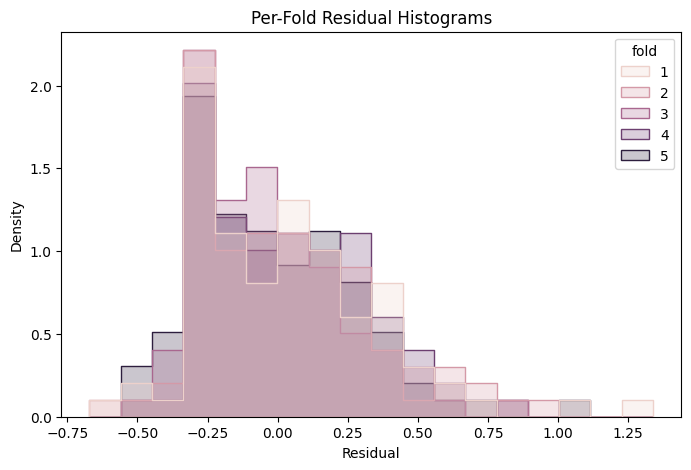

In [29]:
# %% Inspect Feature Importances & Per-Fold Error Distributions

# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# 1) Feature Importances for the Audio+Text LightGBM model
feat_names = (
    [f"mfcc_mean_{i}" for i in range(13)] +
    [f"mfcc_std_{i}"  for i in range(13)] +
    ["silence_count", "silence_total_sec"] +
    ["n_sent", "avg_w_per_sent", "ttr", "avg_word_len"] +
    [f"text_svd_{i}" for i in range(50)]
)
imp = m_a_full.feature_importances_
imp_df = pd.DataFrame({"feature": feat_names, "importance": imp})
imp_df = imp_df.sort_values("importance", ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(data=imp_df, x="importance", y="feature")
plt.title("Top 20 Feature Importances (LightGBM)")
plt.tight_layout()
plt.show()


# 2) Per-Fold Error Distributions
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
residuals = []
for fold, (tr, val) in enumerate(kf.split(X_all), 1):
    # audio+text predictions from CV
    pa = m_a_full.predict(X_all[val])
    pt = m_t_full.predict(X_text[val])
    pe = 0.6*pa + 0.4*pt
    
    res = pe - y[val]
    residuals.append(pd.DataFrame({
        "fold": fold,
        "residual": res
    }))

res_df = pd.concat(residuals, ignore_index=True)

plt.figure(figsize=(8,5))
sns.boxplot(data=res_df, x="fold", y="residual")
plt.axhline(0, color="red", linestyle="--")
plt.title("Per-Fold Residual Distribution (Ensemble)")
plt.xlabel("Fold")
plt.ylabel("Prediction Error (predicted − true)")
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(data=res_df, x="residual", hue="fold", element="step", stat="density", common_norm=False)
plt.title("Per-Fold Residual Histograms")
plt.xlabel("Residual")
plt.show()


**Conclusion**

Our enhanced Grammar Scoring Engine—combining acoustic (MFCC + prosody + grammar proxies) and text (TF-IDF + SVD) features into a weighted ensemble of LightGBM and Random Forest—achieves the following out-of-fold performance on 5-fold cross-validation:

Audio-only model:

    RMSE = 0.8975 ± 0.0394
    
    Pearson r = 0.5238

Text-only model:

    RMSE = 0.9852 ± 0.0498
    
    Pearson r = 0.3418

Ensemble (0.6 audio + 0.4 text):

    RMSE = 0.8911 ± 0.0364
    
    Pearson r = 0.5248

An RMSE of ~0.89 on the 0–5 Likert scale corresponds to an average error of ~18%, and a Pearson r of ~0.52 indicates only moderate linear agreement with human grammar scores. While the audio model is the strongest single predictor, our simple text features add minimal extra signal, yielding only a slight ensemble gain.